In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import folium

from src.manage_precipitation_data import create_tp_daily_summary, create_tp_monthly_aggregate, create_list_lat_long

# Process Precipitation Data

- open `csv` files
- process data

The `geomaps.ipynb` creates 24h and daily dataset for all points in a grid covering London and Apulia, Italy region. In this notebook, we process the creted `.csv` file to implement functions calculating different statistics such as yearly, monthly, mean, median mean and max values. The geomaps notebook works on a different Conda evn using the geopandas libraries. As for this environment, the aim is also creating spatial visualization using folium.

## Daily `csv` data

Starting from the downloaded `.grib` files we created different hourly and daily dataset in `csv` format. This files contain the data for all points in the grid considered when downloading the `.grib` files for Total Precipitation measurements. London data usually contains 4 points in the grid while `puglia` data 177 points. The idea is to compare the mean of the 4 different points in the london data with each point in the grid of Apulia data, to compare different part of the Italian region and the data in London. The starting hypothesis is:

> In Apulia region it rains more (in quantity) than in London - but less often

What we want to verify if this is true considering the mean precipitation for the entire region and for all diffent points.

- Strategy 1 - concatenating daily data into one dataframe

For each create daily dataset, we can create a single file and then execute some analysis on data (e.g. multi year trends).

In [2]:
# from pathlib import Path

# folder_path = Path('./output')

# # Files containing 'puglia_daily'
# puglia_files = [f for f in folder_path.glob('*.parquet') if 'puglia_daily' in f.name]

# # Files containing 'london_daily'
# london_files = [f for f in folder_path.glob('*.parquet') if 'london_daily' in f.name]

In [3]:
from pathlib import Path


def create_daily_rainfall_dataframe(file_path = './output', location = 'london', debug = False):
    # retrieve all files for location
    folder_path = Path('./output')
    string_in_filename = location + '_daily'
    location_files = [f for f in folder_path.glob('*.parquet') if string_in_filename in f.name]
    
    # open each files and create a list of dataframe
    dfs = []
    for file in location_files:
        df = pd.read_parquet(file)
        dfs.append(df)

    # concat list of dataframes
    df_all = pd.concat(dfs, axis = 0).sort_values('time_dt').reset_index(drop=True)
    if debug:
        n_points = len(create_list_lat_long(df_all))
        n_days = ((df_all['time_dt'].max() - df_all['time_dt'].min()).days+1)
        print(f"number of expected rows = {n_points*n_days}, number of returned rows = {df_all.shape[0]}")
    return(df_all)

def transform_data_datetime(df):
    df = df.copy()
    df['year'] = df['time_dt'].dt.year
    df['month int'] = df['time_dt'].dt.month
    df['month'] = df['time_dt'].dt.strftime('%b')
    df['month'] = pd.Categorical(df['month'], categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ordered=True)

    df['day'] = df['time_dt'].dt.day


    return df

In [4]:
df_all_puglia = create_daily_rainfall_dataframe(location='puglia', debug=True)
df_all_london = create_daily_rainfall_dataframe(location='london', debug=True)

number of expected rows = 1001466, number of returned rows = 1001466
number of expected rows = 67884, number of returned rows = 67884


In [5]:
def rainfall_yearly_summary(df_in, location = 'london'):
    # create year/month/day column
    df_data = transform_data_datetime(df_in.copy())
    lat_long_list = create_list_lat_long(df_data)

    list_dfs = []
    for coord in lat_long_list:
        df = (df_data[(df_data['latitude'] == coord[0]) & (df_data['longitude'] == coord[1])]
            .groupby('year')
            .agg(
                yearly_tp_mm = ('tp_mm', 'sum'),
                lat = ('latitude','first'),
                lon = ('longitude', 'first')
            )
            ).reset_index().rename(columns = {'lat' : 'latitude', 'lon' : 'longitude'})
        list_dfs.append(df)

    df_yearly_sum = pd.concat(list_dfs, axis = 0)
    # coordinates mean for each year

    df_yearly_mean = (df_yearly_sum
                        .groupby('year')['yearly_tp_mm']
                        .mean()
                        .reset_index()
                        )
    
    fname_yearly_sum = '../streamlit/data/data_' + location + '_yearly_sum_all_points.parquet'
    fname_yearly_mean = '../streamlit/data/data_' + location + '_yearly_mean.parquet'

    df_yearly_sum.to_parquet(fname_yearly_sum)
    df_yearly_mean.to_parquet(fname_yearly_mean)

    return(df_yearly_sum, df_yearly_mean)
    

In [6]:
data_london_yearly_sum, data_london_yearly_mean = rainfall_yearly_summary(df_all_london, location='london')
data_puglia_yearly_sum, data_puglia_yearly_mean = rainfall_yearly_summary(df_all_puglia, location='puglia')


In [9]:
london_yearly_mean = data_london_yearly_mean.copy()
puglia_yearly_mean = data_puglia_yearly_mean.copy()

london_yearly_mean['location'] = 'london'
puglia_yearly_mean['location'] = 'apulia'

df_plot = pd.concat([london_yearly_mean, puglia_yearly_mean])
df_plot = df_plot[df_plot['year'] > 2009]
df_plot

,year,yearly_tp_mm,location
1,2010,639.058333,london
2,2011,535.083333,london
3,2012,913.625000,london
4,2013,711.275000,london
5,2014,853.133333,london
6,2015,684.633333,london
7,2016,638.983333,london
8,2017,706.383333,london
9,2018,620.941667,london
10,2019,789.633333,london


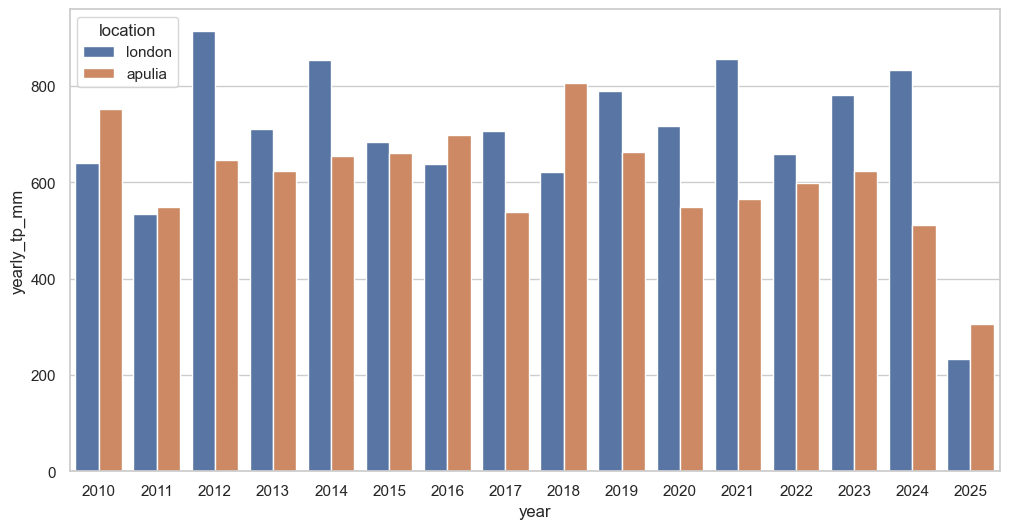

In [11]:
fig_size = (12,6)

sns.set_theme(style="whitegrid")
plt.figure(figsize=fig_size)

sns.barplot(
    data = df_plot,
    x = 'year',
    y = 'yearly_tp_mm',
    hue = 'location'
);

In [98]:


#########

year = 2020
puglia_yearly_tp_points = data_puglia_yearly_sum[data_puglia_yearly_sum['year'] == year]


tp_london_yearly_mean = np.round(london_yearly_mean[london_yearly_mean['year'] == year]['yearly_tp_mm'].values[0])

# Create a base map centered on your data
center_lat = puglia_yearly_tp_points['latitude'].mean()
center_lon = puglia_yearly_tp_points['longitude'].mean()
m = folium.Map(location=[center_lat, center_lon], 
               zoom_start=8,
               min_zoom=7,
               max_zoom=9)

# Define color mapping based on tp_mm values
def get_color(tp_mm_value, tp_london_yearly_mean):
    if tp_mm_value < tp_london_yearly_mean:
        return 'orange'
    else:
        return 'blue'

# Add circles to the map
for idx, row in puglia_yearly_tp_points.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=9,
        popup=f"({row['latitude'], row['longitude'] }) tp_mm: {row['yearly_tp_mm']}",
        color=get_color(row['yearly_tp_mm'], tp_london_yearly_mean),
        fill=True,
        fillColor=get_color(row['yearly_tp_mm'], tp_london_yearly_mean),
        fillOpacity=0.7
    ).add_to(m)

# Display the map
m

## Precipitation Time series

Analyzing time_series files. It should contain the mean of all long/lat data for inputted values. `tp` should be cumulative value.

> To Do: Considering for London data the long/lat closer to Hampstead

1. Create column for rainfall in mm
2. Threshold the rainfall: values under 0.09 are set to 0.0 and then we round to one decimal digit.
2. Create columns for date/hour
3. Group by date and take max - checking it's the same as 23 hour, latest hour.

In [2]:
data_london_2020 = pd.read_csv('./data/2020_london_era5_precipitation_time_series.csv',comment = '#')
data_puglia_2020 = pd.read_csv('./data/2020_puglia_era5_precipitation_time_series.csv',comment = '#')
data_london_2021 = pd.read_csv('./data/2021_london_era5_precipitation_time_series.csv',comment = '#')
data_puglia_2021 = pd.read_csv('./data/2021_puglia_era5_precipitation_time_series.csv',comment = '#')
data_london_2022 = pd.read_csv('./data/2022_london_era5_precipitation_time_series.csv',comment = '#')
data_puglia_2022 = pd.read_csv('./data/2022_puglia_era5_precipitation_time_series.csv',comment = '#')
data_london_2023 = pd.read_csv('./data/2023_london_era5_precipitation_time_series.csv',comment = '#')
data_puglia_2023 = pd.read_csv('./data/2023_puglia_era5_precipitation_time_series.csv',comment = '#')
data_london_2024 = pd.read_csv('./data/2024_london_era5_precipitation_time_series.csv',comment = '#')
data_puglia_2024 = pd.read_csv('./data/2024_puglia_era5_precipitation_time_series.csv',comment = '#')

In [3]:
data_puglia_2020.head()

,step,number,surface,valid_time,tp
0,1 days 00:00:00,0,0.0,2020-01-01 00:00:00,0.000001
1,0 days 01:00:00,0,0.0,2020-01-01 01:00:00,0.000000
2,0 days 02:00:00,0,0.0,2020-01-01 02:00:00,0.000000
3,0 days 03:00:00,0,0.0,2020-01-01 03:00:00,0.000000
4,0 days 04:00:00,0,0.0,2020-01-01 04:00:00,0.000000


In [9]:
data_london_2020.shape[0]/24

366.0

In [ ]:
df_london_2020 = create_tp_daily_summary(data_london_2020, year=2020)
df_puglia_2020 = create_tp_daily_summary(data_puglia_2020, year=2020)
df_london_2021 = create_tp_daily_summary(data_london_2021, year=2021)
df_puglia_2021 = create_tp_daily_summary(data_puglia_2021, year=2021)
df_london_2022 = create_tp_daily_summary(data_london_2022, year=2022)
df_puglia_2022 = create_tp_daily_summary(data_puglia_2022, year=2022)
df_london_2023 = create_tp_daily_summary(data_london_2023, year=2023)
df_puglia_2023 = create_tp_daily_summary(data_puglia_2023, year=2023)
df_london_2024 = create_tp_daily_summary(data_london_2024, year=2024)
df_puglia_2024 = create_tp_daily_summary(data_puglia_2024, year=2024)

In [ ]:
london_monthly_2020 = create_tp_monthly_aggregate(df_london_2020)
puglia_monthly_2020 = create_tp_monthly_aggregate(df_puglia_2020)
london_monthly_2021 = create_tp_monthly_aggregate(df_london_2021)
puglia_monthly_2021 = create_tp_monthly_aggregate(df_puglia_2021)
london_monthly_2022 = create_tp_monthly_aggregate(df_london_2022)
puglia_monthly_2022 = create_tp_monthly_aggregate(df_puglia_2022)
london_monthly_2023 = create_tp_monthly_aggregate(df_london_2023)
puglia_monthly_2023 = create_tp_monthly_aggregate(df_puglia_2023)
london_monthly_2024 = create_tp_monthly_aggregate(df_london_2024)
puglia_monthly_2024 = create_tp_monthly_aggregate(df_puglia_2024)

In [ ]:
london_monthly_2024.columns

In [ ]:
print(f"london 2020 yearly tp = {london_monthly_2020['monthly_tp_mm'].sum()}")
print(f"puglia 2020 yearly tp = {puglia_monthly_2020['monthly_tp_mm'].sum()} \n")
print(f"london 2021 yearly tp = {london_monthly_2021['monthly_tp_mm'].sum()}")
print(f"puglia 2021 yearly tp = {puglia_monthly_2021['monthly_tp_mm'].sum()} \n")
print(f"london 2022 yearly tp = {london_monthly_2022['monthly_tp_mm'].sum()}")
print(f"puglia 2022 yearly tp = {puglia_monthly_2022['monthly_tp_mm'].sum()} \n")
print(f"london 2023 yearly tp = {london_monthly_2023['monthly_tp_mm'].sum()}")
print(f"puglia 2023 yearly tp = {puglia_monthly_2023['monthly_tp_mm'].sum()} \n")
print(f"london 2024 yearly tp = {london_monthly_2024['monthly_tp_mm'].sum()}")
print(f"puglia 2024 yearly tp = {puglia_monthly_2024['monthly_tp_mm'].sum()} \n")

In [ ]:
mmonth = 'Mar'
data_plot = df_london_2020[df_london_2020['month_str'] == mmonth].copy()
data_plot['day'] = data_plot['valid_date_dt'].dt.day

In [ ]:
fig_size = (12,6)

sns.set_theme(style="whitegrid")
plt.figure(figsize=fig_size)

sns.barplot(
    data = data_plot,
    x = 'day',
    y = 'tp_mm'
);

In [ ]:
data_plot['tp_mm'].sum()

In [ ]:
fig_size = (12,6)

sns.set_theme(style="whitegrid")
plt.figure(figsize=fig_size)

sns.barplot(
    data = london_monthly_2024,
    x = 'month_int',
    y = 'monthly_tp_mm'
)

In [ ]:
fig_size = (12,6)

sns.set_theme(style="whitegrid")
plt.figure(figsize=fig_size)

sns.barplot(
    data = puglia_monthly_2024,
    x = 'month_int',
    y = 'monthly_tp_mm'
)

In [ ]:
fig_size = (12,6)

sns.set_theme(style="whitegrid")
plt.figure(figsize=fig_size)

ax = sns.scatterplot(
    data=df_puglia_2024,
    x='valid_date_dt',
    y='tp_mm'
    );

ax = sns.lineplot(
    data=df_puglia_2024,
    x='valid_date_dt',
    y='tp_mm'
    );

In [ ]:
df_london_2024

In [ ]:
data_puglia_2020_lf = pd.read_csv('./data/2020_puglia_era5_precipitation_long_format.csv',comment = '#')
data_puglia_2020_lf.shape

In [ ]:
data_puglia_2020_lf['latitude'].nunique()

In [ ]:
data_puglia_2020_lf['longitude'].nunique()

In [ ]:
18*32

In [ ]:
(18*32)*24*365

In [ ]:
data_puglia_2020_lf['latitude'].unique()[10]

In [ ]:
lats = data_puglia_2020_lf['latitude'].unique()
lons = data_puglia_2020_lf['longitude'].unique()
latit = []
longit = []
tp_sum = []

for lat in lats:
    for lon in lons:
        df = data_puglia_2020_lf[(data_puglia_2020_lf['latitude'] == lat) &
                                 (data_puglia_2020_lf['longitude'] == lon)]
        if df.shape[0] != 0:
            # print(f"lat = {lat}, lon = {lon}, df_shape = {df.shape}")
            latit.append(lat)
            longit.append(lon)
            df_data = df[(df['latitude'] == lat) & (df['longitude'] == lon)].copy()
            test = create_tp_daily_summary(df_data, year=2020)
            tp_sum.append(test['tp_mm'].sum())
            
# for lat in lats:
#     print(f"lat = {lat}, ")

In [ ]:
df_map = pd.DataFrame(
        {
        'latitude' : latit,
        'longitude' : longit,
        'tp_mm_year_2022' : tp_sum
        }
        )

In [ ]:
df_map['tp_mm_year_2022'].mean()

In [ ]:
df_map['tp_mm_year_2022'].min()

In [ ]:
df_map['tp_mm_year_2022'].max()

In [ ]:
sns.histplot(
    data=df_map,
    x = 'tp_mm_year_2022'
);

In [ ]:
import folium

# Assuming your dataframe is called 'df'
# Create a base map centered on your data
center_lat = df_map['latitude'].mean()
center_lon = df_map['longitude'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

# Define color mapping based on tp_mm values
def get_color(tp_mm_value):
    if tp_mm_value < 490:
        return 'blue'
    elif tp_mm_value < 600:
        return 'green'
    elif tp_mm_value < 750:
        return 'yellow'
    else:
        return 'red'

# Add circles to the map
for idx, row in df_map.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=8,
        popup=f"tp_mm: {row['tp_mm_year_2022']}",
        color=get_color(row['tp_mm_year_2022']),
        fill=True,
        fillColor=get_color(row['tp_mm_year_2022']),
        fillOpacity=0.7
    ).add_to(m)

# Display the map
m

In [ ]:
import plotly.express as px

fig_size = (12,12)

sns.set_theme(style="whitegrid")
plt.figure(figsize=fig_size)

fig = px.scatter_mapbox(
    df_map, 
    lat="latitude", 
    lon="longitude", 
    color="tp_mm_year_2022",
    size_max=15,
    zoom=5,
    mapbox_style="open-street-map",
    title="Precipitation Map",
    color_continuous_scale="Viridis"
)

fig.show();

In [ ]:
data_puglia_2020_lf[(data_puglia_2020_lf['step'].str[0] == '1') & 
                    (data_puglia_2020_lf['time'] == '2020-01-03') &
                    (data_puglia_2020_lf['latitude'] == 40.5)]

In [ ]:
data_puglia_2020_lf[ (data_puglia_2020_lf['step'].str[0] == '1') & 
                    (data_puglia_2020_lf['time'] == '2020-01-03') &
                    (data_puglia_2020_lf['latitude'] == 40.899999999999984)]

In [ ]:
data_puglia_2020_409_162 = data_puglia_2020_lf[(data_puglia_2020_lf['latitude'] == 40.899999999999984) &
                                               (data_puglia_2020_lf['longitude'] == 16.2)]

In [ ]:
data_puglia_2020_409_162

In [ ]:
test_2020 = create_tp_daily_summary(data_puglia_2020_409_162, year=2020)
test_2020['tp_mm'].sum()

In [ ]:
data_puglia_2020_418_160

In [ ]:
test_2020 = create_tp_daily_summary(data_puglia_2020_418_153, year=2020)

In [ ]:
test_2020['tp_mm'].sum()

In [ ]:
8784/24

In [ ]:
data_puglia_2020_lf.shape

In [ ]:
data_puglia_2020_lf['longitude'].nunique()

In [ ]:
data_puglia_2020_lf['latitude'].nunique()

In [ ]:
data_puglia_2020['step'].unique()

In [ ]:
data_puglia_2020[data_puglia_2020['step'].str[0] =='1']['tp'].sum()

-------------------

In [ ]:
from datetime import timedelta

def create_tp_daily_summary(df_data, year = 2025, threshold = 0.1):
    # creating `tp_mm`
    df = df_data.copy()
    df['tp_mm'] = 1000*df['tp']

    # Creating valid date column
    df['valid_time_dt'] = pd.to_datetime(df['valid_time'])
    df['valid_date'] = df['valid_time_dt'].dt.date
    mask_hour_0 = df['valid_time_dt'].dt.hour == 0
    df.loc[mask_hour_0, 'valid_date'] = df.loc[mask_hour_0, 'valid_date'] - timedelta(days=1)

    # thresholding and rounding tp_mm
    df.loc[df['tp_mm'] < threshold, 'tp_mm'] = 0.0
    df['tp_mm'] = np.round(df['tp_mm'], 1)

    # computing daily aggregate
    df['valid_date_dt'] = pd.to_datetime(df['valid_date'])
    df['year'] = df['valid_date_dt'].dt.year

    df_daily_tp_mm = (df[df['year'] == year]
                  .groupby('valid_date_dt')['tp_mm']
                  .max()
                  ).reset_index()
    return(df_daily_tp_mm)


In [ ]:
def create_tp_monthly_aggregate(df_data):
    df_data['month_int'] = df_data['valid_date_dt'].dt.month
    df_data['month_str'] = df_data['valid_date_dt'].dt.strftime('%b')

    tp_monthly_aggregate = (df_data
                            .groupby('month_int')
                            .agg(
                                month_str = ('month_str', 'first'),
                                monthly_tp_mm = ('tp_mm', 'sum')
                                )
                                ).reset_index()
    
    return(tp_monthly_aggregate)

In [ ]:
df_london_2024 = create_tp_daily_summary(df_data,
                                  year=2024)

In [ ]:
london_monthly_2024 = create_tp_monthly_aggregate(df_london_2024)
london_monthly_2024.head()

In [ ]:
london_monthly_2024['monthly_tp_mm'].sum()

In [ ]:
puglia_monthly_2024 =create_tp_monthly_aggregate(df_test)
puglia_monthly_2024.head()

In [ ]:
df_test['month_int'] = df_test['valid_date_dt'].dt.month
df_test['month_str'] = df_test['valid_date_dt'].dt.strftime('%b')

In [ ]:
(df_test
 .groupby('month_int')
 .agg(
     month_str = ('month_str', 'first'),
     monthly_tp_mm = ('tp_mm', 'sum')
 )
).reset_index()


In [ ]:
df_test

In [ ]:
fig_size = (12,6)


sns.set_theme(style="whitegrid")
plt.figure(figsize=fig_size)

ax = sns.scatterplot(
    data=df_test,
    x='valid_date_dt',
    y='tp_mm'
    );

ax = sns.lineplot(
    data=df_test,
    x='valid_date_dt',
    y='tp_mm'
    );

In [ ]:
# creating `tp_mm`

df_data['tp_mm'] = 1000*df_data['tp']

In [ ]:
df_data.head(3)

The raws with 1 days contains the cumulative sum of rainfall. To consider the total rainfall for each day, we should take the 00 hour of each day and scale back by one day. So, to assign the 2025-01-01 tp, we need to extract the "00:00:00" hour of the next day `valid_date`

In [ ]:
# Creating valid date

from datetime import timedelta

# # Method 2 - Corrected for date objects
# df_london_2025_reduced['valid_date'] = df_london_2025_reduced['date']  # Start with original date
# mask_hour_0 = df_london_2025_reduced['hour'] == 0
# df_london_2025_reduced.loc[mask_hour_0, 'valid_date'] = df_london_2025_reduced.loc[mask_hour_0, 'date'] - timedelta(days=1)

df_data['valid_time_dt'] = pd.to_datetime(df_data['valid_time'])
df_data['valid_date'] = df_data['valid_time_dt'].dt.date
mask_hour_0 = df_data['valid_time_dt'].dt.hour == 0
df_data.loc[mask_hour_0, 'valid_date'] = df_data.loc[mask_hour_0, 'valid_date'] - timedelta(days=1)

At this step, we can save the daily data as `pkl` file if needed for different analysis around the time of the day.

In [ ]:
starting_date = df_data[df_data['valid_time'] == df_data['valid_time'].min()]['valid_time_dt'].dt.strftime('%Y-%m-%d').values[0].replace('-','_')
ending_date = df_data[df_data['valid_time_dt'] == df_data['valid_time_dt'].max()]['valid_time_dt'].dt.strftime('%Y-%m-%d').values[0].replace('-','_')

starting_date + '_' + ending_date

# ['valid_time_dt'].dt.strftime('%Y-%m-%d')


- rounding `tp_mm`

We set all values below 0.09 to 0 and then round `tp_mm` to the first decimal digit 

In [ ]:
# threshold set
threshold = 0.1
df_data.loc[df_data['tp_mm'] < threshold, 'tp_mm'] = 0.0
df_data['tp_mm'] = np.round(df_data['tp_mm'], 1)


In [ ]:
df_data.head()

## Daily Aggregate

The following code refers to annual data. We will expand while dealing with multi years dataset.

In [ ]:
df_data['valid_date_dt'] = pd.to_datetime(df_data['valid_date'])

In [ ]:
df_data['year'] = df_data['valid_date_dt'].dt.year
# df_data['month_int'] = df_data['valid_date_dt'].dt.month
# df_data['month'] = df_data['valid_date_dt'].dt.strftime('%b')

In [ ]:
df_daily_tp_mm = (df_data[df_data['year'] == 2025]
                  .groupby('valid_date_dt')['tp_mm']
                  .max()
                  ).reset_index()

In [ ]:
df_daily_tp_mm.head()

In [ ]:
fig_size = (12,6)


sns.set_theme(style="whitegrid")
plt.figure(figsize=fig_size)

ax = sns.scatterplot(
    data=df_daily_tp_mm,
    x='valid_date_dt',
    y='tp_mm'
    );

ax = sns.lineplot(
    data=df_daily_tp_mm,
    x='valid_date_dt',
    y='tp_mm'
    );